In [1]:
import propagation_methods as propag
import grid_generation as grid
import bounds_common as bounds
import barriers as barriers
import probability_mass_computation as proba
import plot_methods as plot

import numpy as np

### **The linear bimodal case** 

In this experiement, $x_0$ follows a GMM with two components, and the system is linear $f(x_t) = Ax_{t}$, where $A$ is known. We assume $\varepsilon_t$ to be normally distributed, with a fixed stationary covariance, i.e. $\varepsilon_t \sim \mathcal{N}([0, 0], \Sigma_{\varepsilon})$.

We aim to compute GMM approximations $\hat{p}(x_t)$ for $10$ time steps, as well as bounds on their TV distances to the true distributions $p(x_t)$.

**Numerical note**: The theory related to this experiement does NOT demand that those Gaussians should have uncorrelated components. However, our current code implementation does assume that.

##### 1) Defining system parameters

In [2]:
METHOD = 'linear'

A = np.array(
          [
              [0.84, 0.1],
              [0.05, 0.72]
          ])

params = [A]

In [3]:
#Initial distribution
sigma = 0.001

mean_initial_state_mode1 = np.array([2.8, 2.8])
var_initial_state = np.array([sigma, sigma]) #Assumes uncorrelation (this could be relaxed in further upgrades)

mean_initial_state_mode2 = np.array([2.4, 2.8])

#Noise structure
sigma_noise = 0.001

mean_noise = [0, 0]
var_noise = np.array([sigma_noise/2, 2*sigma_noise]) #Assumes uncorrelation (this could be relaxed in further upgrades)

#Steps ahead for prediction
n_steps_ahead = 1

In [4]:
sigma**0.5

0.03162277660168379

In [5]:
unbounded_region = np.array([[np.inf, np.inf], [np.inf, np.inf]]) #a representation choice for the unbounded region

In [6]:
colors = ['Purples', 'Blues', 'Oranges', 'YlOrBr', 'YlOrRd', 
          'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 
          'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

##### 2) Monte Carlo simulation of the system

We run a MC simulation for the system above in order to understand its (probabilistic) behavior.

Note: We also add a representation for an unsafe set (red square) which will later motivate safety discussions.

In [7]:
barriers_list = barriers.createBarrier(np.array([[1.0, 0.0], [1.5, 0.5]]))
barrier = barriers_list[0]

Hitting proba: 0.0
Hitting proba: 0.0


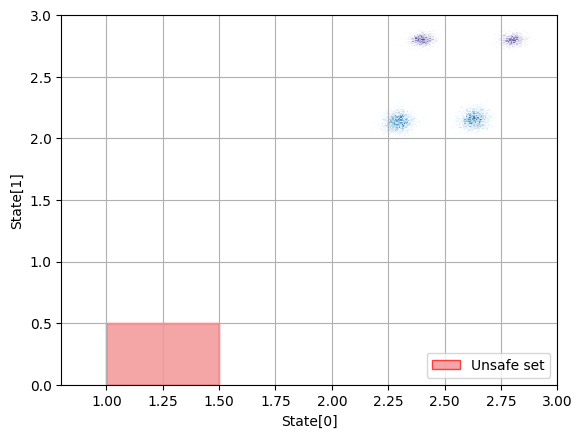

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

n_simulations = 10000
mc_hitting_proba = []

fig, ax = plt.subplots()

rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

for t in range(n_steps_ahead + 1):
    if t == 0:
        mean_initial = [mean_initial_state_mode1, mean_initial_state_mode2]
        states = []
        for n in range(n_simulations):
            index_normal = np.random.choice(2, p = [0.5, 0.5])
            state = propag.getInitialState(mean_initial[index_normal], var_initial_state, 1)
            states.append(state)
        states = np.array(states)
        
    else:
        states = propag.stateOneStepEvolution(states, mean_noise, var_noise, METHOD, params)
    
    #Plot samples
    plt.hist2d(states[:, 0], states[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

    #Compute hitting probability
    hitting_proba = barriers.hittingProbabilityMC(states, barrier)
    mc_hitting_proba.append(hitting_proba)

plt.legend(loc='lower right')

plt.xlim(0.8, 3.0)
plt.ylim(0, 3)
plt.xlabel('State[0]')
plt.ylabel('State[1]')
plt.grid(True)
plt.show()

In [9]:
#Simulation settings
type_partition = 'unequally_linear'  #Options: unequally_linear or equally
tv_bounds = [0.0]
gmm_hitting_proba = [0.0]
n_partitions = [200, 200] #NOT BEING USED FOR THE UNEQUALLY LINEAR, SEE HACKING IN THE GRID FILE
n_sampling_gmm = 5000

vertice_lower_1 = [mean_initial_state_mode1[0] - 4*var_initial_state[0]**0.5, mean_initial_state_mode1[1] - 4*var_initial_state[1]**0.5]
vertice_upper_1 = [mean_initial_state_mode1[0] + 4*var_initial_state[0]**0.5, mean_initial_state_mode1[1] + 4*var_initial_state[1]**0.5]

vertice_lower_2 = [mean_initial_state_mode2[0] - 4*var_initial_state[0]**0.5, mean_initial_state_mode2[1] - 4*var_initial_state[1]**0.5]
vertice_upper_2 = [mean_initial_state_mode2[0] + 4*var_initial_state[0]**0.5, mean_initial_state_mode2[1] + 4*var_initial_state[1]**0.5]

In [10]:
fig, ax = plt.subplots()

for t in range(n_steps_ahead + 1):
    if t == 0:
        hpr_1 = np.array([vertice_lower_1, vertice_upper_1])
        hpr_2 = np.array([vertice_lower_2, vertice_upper_2])
        outer_signature = grid.compute_outer_point([hpr_1, hpr_2], 0.5)

        hpr_partition_1 = grid.createRegionPartitions(hpr_1, n_partitions, type_partition)
        hpr_partition_2 = grid.createRegionPartitions(hpr_2, n_partitions, type_partition)

        regions = np.vstack((hpr_partition_1, hpr_partition_2))

        signatures = grid.placeSignatures(regions)
        double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, np.array([mean_initial_state_mode1, mean_initial_state_mode2]), var_initial_state, np.array([0.5, 0.5]))
        regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)
    
    else:

        tv_bound = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var_noise, METHOD, params)
        tv_bounds.append(tv_bound)

        means_gmm = propag.propagateSignatures(signatures, METHOD, params)
        samples = propag.sampleFromGMM(n_sampling_gmm, double_hat_proba, means_gmm, var_noise)

        #Compute hitting probability
        proba_barrier = proba.gmmProbabilityMassInsideRegion(double_hat_proba, means_gmm, var_noise, barrier)
        gmm_hitting_proba.append(proba_barrier)

        plt.hist2d(samples[:, 0], samples[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

        signatures, regions, outer_signature = grid.updateGridBiModalSimplification(samples, n_partitions, type_partition, t) #TODO: change this to K-means
        
        double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, means_gmm, var_noise, double_hat_proba)
        regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)



rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

plt.legend(loc='lower right')

plt.xlim(0.8, 3)
plt.ylim(0, 3)
plt.xlabel('State[0]')
plt.ylabel('State[1]')
plt.grid(True)
plt.show()

Number of signatures: 167042
Function 'computeSignatureProbabilitiesInParallel' executed in 1.6190s
TV bound at propag step: 0.0056579256607744086
0.0
Number of signatures: 167042


##### Auxiliary